<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#imports" data-toc-modified-id="imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#load-original-subsets:-train,-test-and-split-or..." data-toc-modified-id="load-original-subsets:-train,-test-and-split-or...-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>load original subsets: train, test and split or...</a></span></li><li><span><a href="#...load-my-subsets:-train,-dev,-test" data-toc-modified-id="...load-my-subsets:-train,-dev,-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>...load my subsets: train, dev, test</a></span></li><li><span><a href="#Neural-net-to-make-predictions..." data-toc-modified-id="Neural-net-to-make-predictions...-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Neural net to make predictions...</a></span></li><li><span><a href="#Or-load-LabelPowerset-probas..." data-toc-modified-id="Or-load-LabelPowerset-probas...-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Or load LabelPowerset probas...</a></span></li><li><span><a href="#Static-thresholds" data-toc-modified-id="Static-thresholds-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Static thresholds</a></span></li><li><span><a href="#SGLThresh" data-toc-modified-id="SGLThresh-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>SGLThresh</a></span><ul class="toc-item"><li><span><a href="#SurrogateHeaviside-definition" data-toc-modified-id="SurrogateHeaviside-definition-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>SurrogateHeaviside definition</a></span></li><li><span><a href="#numerical-application" data-toc-modified-id="numerical-application-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>numerical application</a></span></li><li><span><a href="#numerical-application,-for-loop" data-toc-modified-id="numerical-application,-for-loop-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>numerical application, for loop</a></span></li></ul></li><li><span><a href="#NumThresh" data-toc-modified-id="NumThresh-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>NumThresh</a></span><ul class="toc-item"><li><span><a href="#utility-function-for-F1-with-multiprocessing:-TODO" data-toc-modified-id="utility-function-for-F1-with-multiprocessing:-TODO-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>utility function for F1 with multiprocessing: TODO</a></span></li><li><span><a href="#utility-function-for-F1-w/o-multiprocessing" data-toc-modified-id="utility-function-for-F1-w/o-multiprocessing-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>utility function for F1 w/o multiprocessing</a></span></li><li><span><a href="#numerical-application" data-toc-modified-id="numerical-application-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>numerical application</a></span></li><li><span><a href="#for-BCE" data-toc-modified-id="for-BCE-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>for BCE</a></span></li><li><span><a href="#numerical-application-with-BCE" data-toc-modified-id="numerical-application-with-BCE-8.5"><span class="toc-item-num">8.5&nbsp;&nbsp;</span>numerical application with BCE</a></span></li></ul></li></ul></div>

# imports

In [ ]:
# paper http://lpis.csd.auth.gr/publications/tsoumakas-ismir08.pdf

# !pip install scikit-multilearn
# !pip install skorch
# !pip install liac-arff

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data
# from skorch import NeuralNetClassifier

In [11]:
import numpy as np
import sklearn.metrics as metrics
from skmultilearn.dataset import load_dataset
import matplotlib.pyplot as plt
import time

from multiprocessing import Pool
from functools import partial

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split

In [3]:
# http://scikit.ml/datasets.html
from skmultilearn.dataset import available_data_sets
set([x[0] for x in available_data_sets().keys()])

{'Corel5k',
 'bibtex',
 'birds',
 'delicious',
 'emotions',
 'enron',
 'genbase',
 'mediamill',
 'medical',
 'rcv1subset1',
 'rcv1subset2',
 'rcv1subset3',
 'rcv1subset4',
 'rcv1subset5',
 'scene',
 'tmc2007_500',
 'yeast'}

In [7]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
def predict(mydataloader, y, model):
    model.eval()

    all_outputs = torch.zeros_like(y)

    for i_batch, sample_batched in enumerate(mydataloader):

        X_batch, y_batch = sample_batched
        outputs = model(X_batch)
        B = X_batch.size()[0]
        all_outputs[i_batch*B:(i_batch+1)*B]=outputs
    return all_outputs


def print_thresholds(thresh, nb_classes):
    s = ''
    for c in range(nb_classes):
        s+='%.4f '%thresh[c]
    print("auto_thresholds", s)

    
def compute_instance_F1(gt_y, preds):
    num = gt_y*preds
    num = 2*np.sum(num, axis=1)
    den = np.sum(gt_y, axis=1) + np.sum(preds, axis=1)
    return np.mean(num/den)


def unit_test(gt_y, preds):
    print("%.2f"%compute_instance_F1(gt_y, preds))

    
def print_scores(gt_y, preds):
    print(classification_report(gt_y, preds, digits=3))    
    set_accuracy = accuracy_score(gt_y, preds)
    print('set acc: %.3f'%(set_accuracy))
    
    
# def print_scores(gt_y, preds):
#     p2, r2, fscore2, support = precision_recall_fscore_support(gt_y, preds, pos_label=1, average='micro')
#     p3, r3, fscore3, support = precision_recall_fscore_support(gt_y, preds, pos_label=1, average='macro')
#     set_accuracy = accuracy_score(gt_y, preds)
#     print('micro: p:%.2f r:%.2f f1:%.2f'%(100.*p2, 100.*r2, 100.*fscore2))
#     print('macro: p:%.2f r:%.2f f1:%.2f'%(100.*p3, 100.*r3, 100.*fscore3))
#     print('set acc:%.2f instance-F1:%.2f'%(100.*set_accuracy, 100*compute_instance_F1(gt_y, preds)))
    
def compute_accuracy_from_numpy_tensors(gt_y_numpy, preds_numpy):
    acc_per_class = sum(gt_y_numpy==preds_numpy)/len(gt_y_numpy)
    
    gt_y_numpy_vec = np.reshape(gt_y_numpy, -1)
    preds_numpy_vec = np.reshape(preds_numpy, -1)
    acc = sum(gt_y_numpy_vec==preds_numpy_vec)/len(gt_y_numpy_vec)
    print("Acc per class:", acc_per_class)
    print("Acc: %.3f"%acc)


dummy_y = np.array([[1,0,0], [0,1,0]])
dummy_preds = np.array([[1,0,0], [0,0,0]])
unit_test(dummy_y, dummy_preds)

0.50


# load original subsets: train, test and split or...

In [19]:
dataset='bibtex'

X_train, y_train, feature_names, label_names = load_dataset('%s'%(dataset), 'train')
X_test, y_test, _, _ = load_dataset('%s'%(dataset), 'test')

X_train_numpy = X_train.toarray()
X_test_numpy = X_test.toarray()
y_train_numpy = y_train.toarray()
y_test_numpy = y_test.toarray()

bibtex:train - exists, not redownloading
bibtex:test - exists, not redownloading


In [16]:
X_train_numpy, X_dev_numpy, y_train_numpy, y_dev_numpy = train_test_split(
    X_train_numpy, y_train_numpy, test_size=0.33, random_state=42)


In [17]:
X_train_numpy.shape, y_train_numpy.shape, X_dev_numpy.shape, y_dev_numpy.shape, X_test_numpy.shape, y_test_numpy.shape 

((1752, 1836), (1752, 159), (863, 1836), (863, 159), (2515, 1836), (2515, 159))

In [20]:
# np.savez("datasets/%s/%s_train_dev_test.npz"%(dataset, dataset), 
#          X_train_numpy=X_train_numpy, 
#          X_dev_numpy = X_dev_numpy,
#          X_test_numpy = X_test_numpy,
#          y_train_numpy=y_train_numpy, 
#          y_dev_numpy = y_dev_numpy,
#          y_test_numpy = y_test_numpy)

# ...load my subsets: train, dev, test

In [8]:
X_train_pth = torch.tensor(X_train.toarray(), dtype=torch.float)
X_test_pth = torch.tensor(X_test.toarray(), dtype=torch.float)
y_train_pth = torch.tensor(y_train.toarray(), dtype=torch.float)
y_test_pth = torch.tensor(y_test.toarray(), dtype=torch.float)

# y_train = torch.tensor(y_train.toarray(), dtype=torch.float)
# y_test = torch.tensor(y_test.toarray(), dtype=torch.float)

In [9]:
X_train_pth.size(), y_train_pth.size(), X_test_pth.size(), y_test_pth.size()

(torch.Size([4880, 1836]),
 torch.Size([4880, 159]),
 torch.Size([2515, 1836]),
 torch.Size([2515, 159]))

In [10]:
y_train_numpy = y_train_pth.clone().detach().cpu().numpy()
y_test_numpy = y_test_pth.clone().detach().cpu().numpy()

# Neural net to make predictions...

In [18]:
input_dim = X_train.shape[1]
hidden_dim = 200
# output_dim = len(np.unique(y_train.rows))
output_dim = y_train.shape[1]
nb_classes = output_dim

input_dim, hidden_dim, output_dim 

(1836, 200, 159)

In [65]:
train_dataset = data.TensorDataset(X_train_pth, y_train_pth) # create your datset
train_dataloader = data.DataLoader(train_dataset, batch_size=8, shuffle=True)
train_dataloader_noShuffle = data.DataLoader(train_dataset, batch_size=8, shuffle=False)

test_dataset = data.TensorDataset(X_test_pth, y_test_pth) # create your datset
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [58]:
class MultiClassClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(MultiClassClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = self.output(X)
#         X = F.softmax(X, dim=-1)
        X = torch.sigmoid(X)

        return X

In [83]:
model = MultiClassClassifierModule(input_dim, hidden_dim, output_dim)

criterion = torch.nn.BCELoss(reduction="mean")
# criterion = torch.nn.BCEWithLogitsLoss(reduction="mean")

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

MultiClassClassifierModule(
  (dropout): Dropout(p=0.5)
  (hidden): Linear(in_features=1836, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=159, bias=True)
)


In [84]:
num_epochs = 5


losses = []
for epoch in range(num_epochs):
    
    debut = time.time()
    model.train()
    
    for i_batch, sample_batched in enumerate(train_dataloader):
        
        X_batch, y_batch = sample_batched
        
#         print(i_batch, X_batch.size(), y_batch.size())
    
        # Forward pass
        # inputs:  predictions_tensor
        outputs = model(X_batch)
#         print(outputs.size())
    #     if epoch % 10 == 0:
    #         print(outputs[-1])
        loss = criterion(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        losses.append(loss)
    
    duree_epoch = time.time() - debut

    print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
           .format(epoch+1, num_epochs, loss, duree_epoch))

Epoch [1/5], Loss: 0.0639, Duration: 2.2 s
Epoch [2/5], Loss: 0.0488, Duration: 2.1 s
Epoch [3/5], Loss: 0.0401, Duration: 1.8 s
Epoch [4/5], Loss: 0.0412, Duration: 2.1 s
Epoch [5/5], Loss: 0.0212, Duration: 2.1 s


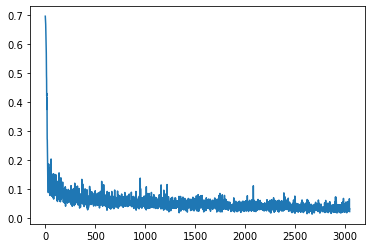

In [85]:
plt.plot(losses)

In [86]:
train_outputs = predict(train_dataloader_noShuffle, y_train_pth, model)
test_outputs = predict(test_dataloader, y_test_pth, model)

train_outputs_numpy = train_outputs.clone().detach().cpu().numpy()
test_outputs_numpy = test_outputs.clone().detach().cpu().numpy()
# y_test[:5], test_outputs[:5]

# Or load LabelPowerset probas...

In [11]:
arr = np.load("datasets/bibtex/bibtex_LabelPowerset_train_test_proba.npz")
# print(arr["train_proba"])

train_outputs_numpy = arr["train_proba"]
test_outputs_numpy = arr["test_proba"]
train_outputs_numpy.shape, test_outputs_numpy.shape

((4880, 159), (2515, 159))

# Static thresholds

In [12]:
static_thresh = 0.3
test_pred_numpy = test_outputs_numpy>static_thresh
train_pred_numpy = train_outputs_numpy>static_thresh

In [13]:
print("train")
print_scores(y_train, train_pred_numpy)
print("test")
print_scores(y_test, test_pred_numpy)
# compute_accuracy_from_numpy_tensors(y_test_numpy, test_pred_numpy)

# train
# micro: p:87.52 r:58.04 f1:69.80
# macro: p:87.38 r:48.18 f1:55.83
# test
# micro: p:68.03 r:31.09 f1:42.68
# macro: p:43.28 r:20.66 f1:24.56

train
micro: p:94.95 r:85.97 f1:90.24
macro: p:95.37 r:83.78 f1:88.98
test
micro: p:62.07 r:32.17 f1:42.37
macro: p:43.58 r:22.99 f1:26.53


/home/thomas/tools/miniconda2/envs/keras-sincnet-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# SGLThresh

## SurrogateHeaviside definition

In [14]:
# device = 'cpu'

class SurrogateHeaviside(torch.autograd.Function):
    
    # Activation function with surrogate gradient
#     sigma = 100.0

    @staticmethod 
    def forward(ctx, input, sigma):
        
        output = torch.zeros_like(input)
        output[input > 0] = 1.0
        ctx.save_for_backward(input, sigma)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        
        input, sigma = ctx.saved_tensors
        grad_input = grad_output.clone()
        # approximation of the gradient using sigmoid function
        grad = grad_input*torch.sigmoid(sigma*input)*torch.sigmoid(-sigma*input)
        
        grad_sigma = None
        
        return grad, grad_sigma

threshold_fn = SurrogateHeaviside.apply


class ThresholdModel(nn.Module):
    def __init__(self, threshold_fn, t=0.5, nb_classes=10):
        super(ThresholdModel, self).__init__()
        
        # define nb_classes seuils differents, initialisés à 0.5

#         self.dense = torch.nn.Linear(10, 10)

        self.thresh = torch.nn.Parameter(t*torch.ones(nb_classes), requires_grad=True)
        self.threshold_fn = threshold_fn
        
    
    def forward(self, x, sigma):
        out = self.threshold_fn(x.to(device, dtype=torch.float)-self.thresh.to(device, dtype=torch.float), sigma)
#         out = out.clamp_(min=0.01, max=0.99)
        # out = self.dense(x.to(device, dtype=torch.float))
        # out = F.sigmoid(out)
        # out = self.threshold_fn(out-F.sigmoid(self.thresh.to(device, dtype=torch.float)))
        return out

    
    def clamp(self):
        
        self.thresh.data.clamp_(min=0., max=1.)

        
def F1_loss_objective(binarized_output, y_true):
    # let's first convert binary vector prob into logits
#     prob = torch.clamp(prob, 1.e-12, 0.9999999)
    
#     average = 'macro'
    average = 'micro'
    epsilon = torch.tensor(1e-12)
    
    if average == 'micro':
        y_true = torch.flatten(y_true)
        binarized_output = torch.flatten(binarized_output)
        
    true_positives = torch.sum(y_true * binarized_output, dim=0)
    predicted_positives = torch.sum(binarized_output, dim=0)
    positives = torch.sum(y_true, dim=0)
    precision = true_positives / (predicted_positives + epsilon)
    recall = true_positives / (positives + epsilon)

    f1 = 2 * ((precision * recall) / (precision + recall + epsilon))
#     return precision, recall, f1
    return - f1.mean()
    

## numerical application

In [16]:
pth_test_probs = torch.tensor(test_outputs_numpy, dtype=torch.float).clone().detach().to(device, dtype=torch.float)
pth_train_probs = torch.tensor(train_outputs_numpy, dtype=torch.float).clone().detach().to(device, dtype=torch.float)
pth_test_gt = y_test_pth.to(device, dtype=torch.float)
pth_train_gt = y_train_pth.to(device, dtype=torch.float)

In [21]:
THRESHmodel = ThresholdModel(threshold_fn=threshold_fn, t=0.3, nb_classes=nb_classes)
THRESHmodel = THRESHmodel.to(device, dtype=torch.float)
# criterion = torch.nn.BCELoss(reduction="mean")
criterion = F1_loss_objective

learning_rate = 1e-3
THRESHoptimizer = torch.optim.Adam(THRESHmodel.parameters(), lr=learning_rate)

Epoch [1/200], Loss: -0.9024, Duration: 0.0 s
Epoch [2/200], Loss: -0.9024, Duration: 0.0 s
Epoch [3/200], Loss: -0.9025, Duration: 0.0 s
Epoch [4/200], Loss: -0.9026, Duration: 0.0 s
Epoch [5/200], Loss: -0.9027, Duration: 0.0 s
Epoch [6/200], Loss: -0.9027, Duration: 0.0 s
Epoch [7/200], Loss: -0.9028, Duration: 0.0 s
Epoch [8/200], Loss: -0.9028, Duration: 0.0 s
Epoch [9/200], Loss: -0.9029, Duration: 0.0 s
Epoch [10/200], Loss: -0.9030, Duration: 0.0 s
Epoch [11/200], Loss: -0.9031, Duration: 0.0 s
Epoch [12/200], Loss: -0.9032, Duration: 0.0 s
Epoch [13/200], Loss: -0.9035, Duration: 0.0 s
Epoch [14/200], Loss: -0.9035, Duration: 0.0 s
Epoch [15/200], Loss: -0.9036, Duration: 0.0 s
Epoch [16/200], Loss: -0.9038, Duration: 0.0 s
Epoch [17/200], Loss: -0.9039, Duration: 0.0 s
Epoch [18/200], Loss: -0.9040, Duration: 0.0 s
Epoch [19/200], Loss: -0.9041, Duration: 0.0 s
Epoch [20/200], Loss: -0.9043, Duration: 0.0 s
Epoch [21/200], Loss: -0.9043, Duration: 0.0 s
Epoch [22/200], Loss: 

Epoch [179/200], Loss: -0.9092, Duration: 0.0 s
Epoch [180/200], Loss: -0.9092, Duration: 0.0 s
Epoch [181/200], Loss: -0.9092, Duration: 0.0 s
Epoch [182/200], Loss: -0.9092, Duration: 0.0 s
Epoch [183/200], Loss: -0.9092, Duration: 0.0 s
Epoch [184/200], Loss: -0.9093, Duration: 0.0 s
Epoch [185/200], Loss: -0.9093, Duration: 0.0 s
Epoch [186/200], Loss: -0.9093, Duration: 0.0 s
Epoch [187/200], Loss: -0.9093, Duration: 0.0 s
Epoch [188/200], Loss: -0.9093, Duration: 0.0 s
Epoch [189/200], Loss: -0.9094, Duration: 0.0 s
Epoch [190/200], Loss: -0.9094, Duration: 0.0 s
Epoch [191/200], Loss: -0.9094, Duration: 0.0 s
Epoch [192/200], Loss: -0.9094, Duration: 0.0 s
Epoch [193/200], Loss: -0.9095, Duration: 0.0 s
Epoch [194/200], Loss: -0.9095, Duration: 0.0 s
Epoch [195/200], Loss: -0.9095, Duration: 0.0 s
Epoch [196/200], Loss: -0.9095, Duration: 0.0 s
Epoch [197/200], Loss: -0.9095, Duration: 0.0 s
Epoch [198/200], Loss: -0.9095, Duration: 0.0 s
Epoch [199/200], Loss: -0.9095, Duration

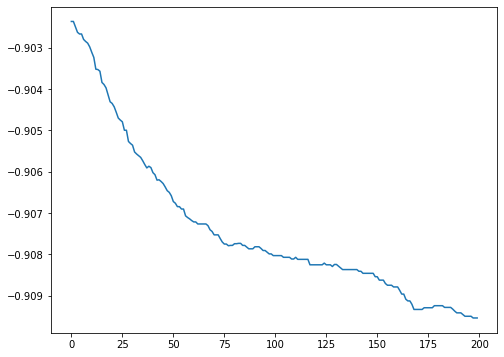

In [22]:
# Train the model, in batch mode
num_epochs = 200
# num_epochs = 12

sigma = torch.nn.Parameter(torch.tensor(100.0), requires_grad=True)

cumul_delta_thresh = torch.zeros(nb_classes,)
delta_thresh = torch.zeros(nb_classes,)

for el in THRESHmodel.parameters():
    PREC_learned_AT_thresholds = el.clone().detach().cpu()

losses = []
for epoch in range(num_epochs):
    
    debut = time.time()
    
    THRESHmodel.train()
    
    # Forward pass
    # inputs:  predictions_tensor
    outputs = THRESHmodel(pth_train_probs, sigma)
    
#     if epoch % 10 == 0:
#         print(outputs[-1])
    loss = criterion(outputs, pth_train_gt)

    # Backward and optimize
    THRESHoptimizer.zero_grad()

    loss.backward()
#     loss.mean().backward()
#         loss.backward(at_batch_y)
    # loss.backward(torch.ones_like(loss))

    THRESHoptimizer.step()
    # THRESHmodel.clamp()
    losses.append(loss)
    
    duree_epoch = time.time() - debut

#     print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
#            .format(epoch+1, num_epochs, loss.mean(), duree_epoch))
    print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
           .format(epoch+1, num_epochs, loss, duree_epoch))

    for el in THRESHmodel.parameters():
        learned_AT_thresholds = el.clone().detach().cpu()

    delta_thresh = learned_AT_thresholds - PREC_learned_AT_thresholds
    cumul_delta_thresh += delta_thresh
    PREC_learned_AT_thresholds = learned_AT_thresholds
#     if epoch % 10 == 0: print('threshs:', learned_AT_thresholds)
    # if torch.sum(delta_thresh) < 0.01: break
    
print('delta:', cumul_delta_thresh)
plt.figure(figsize=(8,6))
plt.plot(losses)

In [23]:
for el in THRESHmodel.parameters():
    learned_AT_thresholds = el.detach().cpu().numpy()
# learned_AT_thresholds

In [24]:
train_pred = train_outputs_numpy>learned_AT_thresholds
test_pred = test_outputs_numpy>learned_AT_thresholds
print("train")
print_scores(y_train, train_pred)
# compute_accuracy_from_numpy_tensors(y_train_numpy, train_pred)
print("test")
print_scores(y_test, test_pred)
# compute_accuracy_from_numpy_tensors(y_test_numpy, test_pred)

# train
# micro: p:87.23 r:59.87 f1:71.01
# macro: p:87.00 r:50.22 f1:57.78
# test
# micro: p:67.37 r:31.65 f1:43.06
# macro: p:43.73 r:21.28 f1:25.40

train
micro: p:96.20 r:86.25 f1:90.95
macro: p:96.54 r:84.18 f1:89.73
test
micro: p:64.48 r:31.26 f1:42.10
macro: p:42.82 r:22.41 f1:25.84


In [ ]:
# print_thresholds(learned_AT_thresholds, nb_classes)

In [ ]:
train
micro: p:83.38 r:43.07 f1:56.80
macro: p:70.37 r:31.97 f1:37.60
test
micro: p:70.68 r:26.67 f1:38.72
macro: p:35.39 r:16.45 f1:19.58

## numerical application, for loop

sigma: 1.0
train
micro: p:97.49 r:84.43 f1:90.49
macro: p:97.66 r:82.31 f1:89.16
test
micro: p:73.87 r:26.21 f1:38.69
macro: p:47.28 r:17.22 f1:21.74
sigma: 10.0
train
micro: p:97.00 r:84.79 f1:90.48
macro: p:97.22 r:82.65 f1:89.17
test
micro: p:71.25 r:27.55 f1:39.73
macro: p:47.09 r:18.46 f1:22.76
sigma: 20.0
train
micro: p:96.74 r:85.00 f1:90.49
macro: p:97.00 r:82.87 f1:89.20
test
micro: p:69.47 r:28.39 f1:40.31
macro: p:45.85 r:19.22 f1:23.36
sigma: 30.0
train
micro: p:96.88 r:85.52 f1:90.85
macro: p:97.12 r:83.42 f1:89.56
test
micro: p:68.81 r:29.19 f1:40.99
macro: p:44.19 r:19.91 f1:23.88
sigma: 40.0
train
micro: p:96.67 r:85.95 f1:91.00
macro: p:96.92 r:83.86 f1:89.72
test
micro: p:67.00 r:30.17 f1:41.60
macro: p:43.28 r:20.98 f1:24.83
sigma: 50.0
train
micro: p:96.61 r:86.11 f1:91.06
macro: p:96.84 r:84.08 f1:89.81
test
micro: p:66.55 r:30.65 f1:41.97
macro: p:44.12 r:21.60 f1:25.38
sigma: 60.0
train
micro: p:96.53 r:86.19 f1:91.07
macro: p:96.75 r:84.16 f1:89.81
test
micro: p

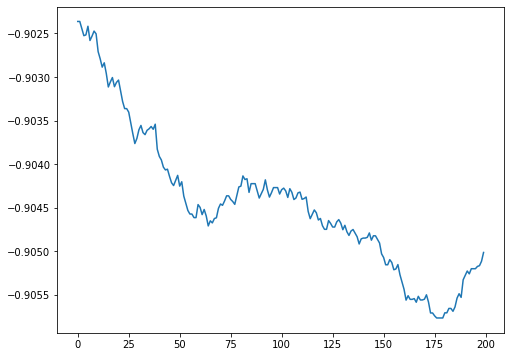

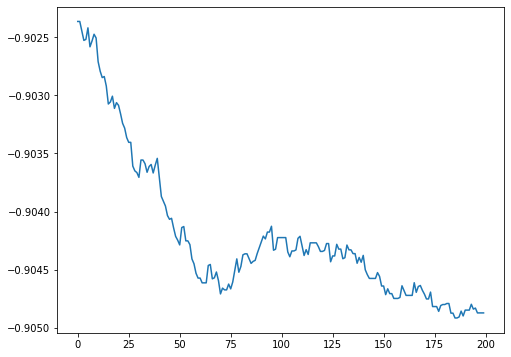

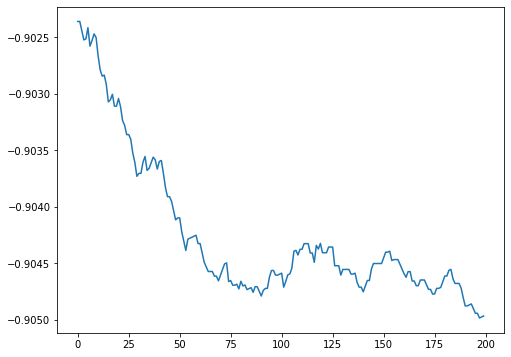

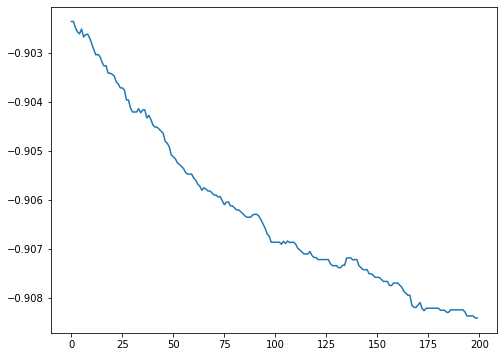

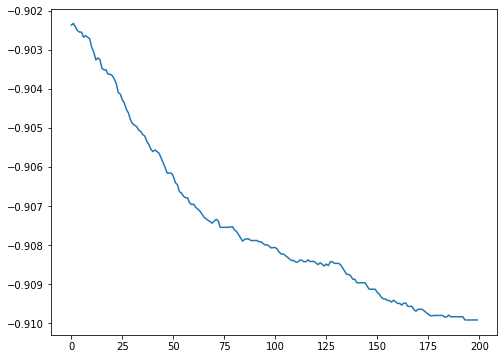

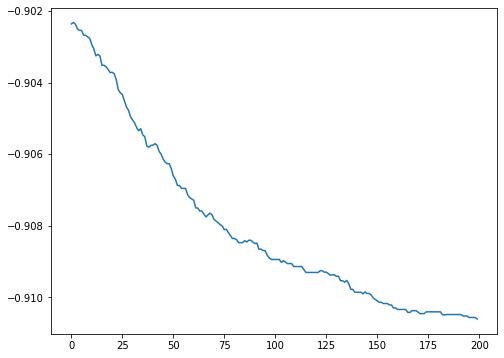

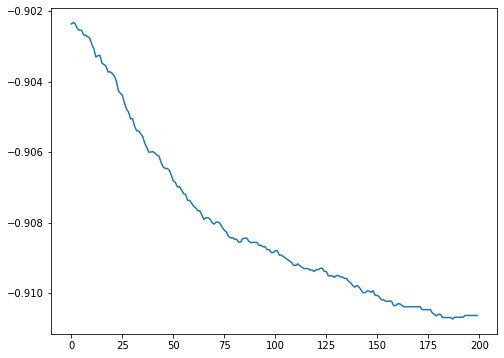

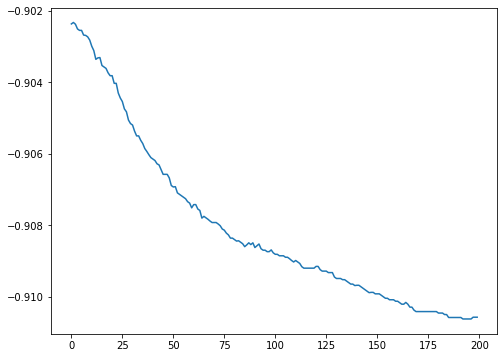

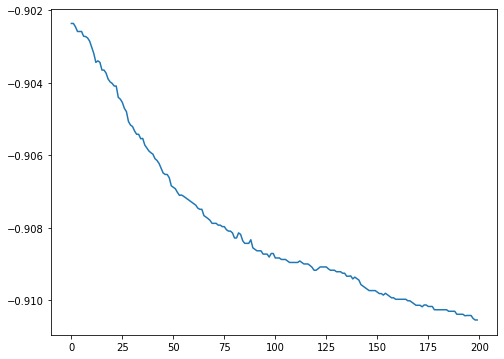

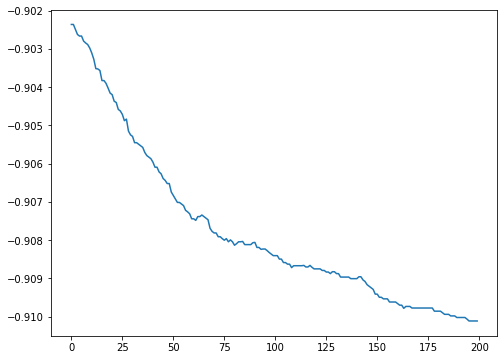

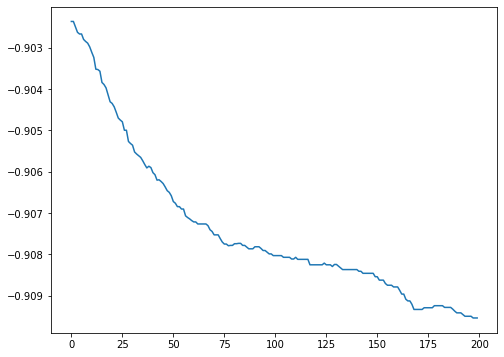

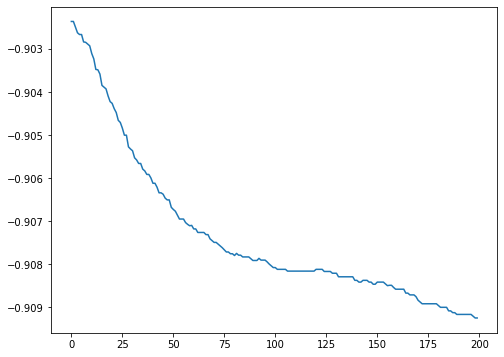

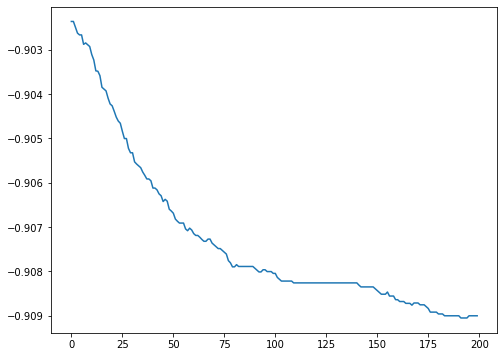

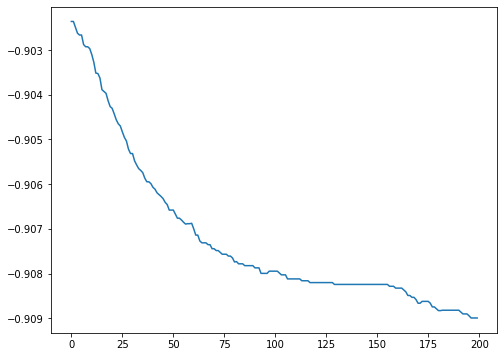

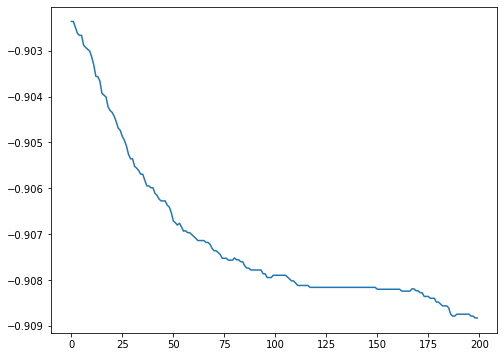

In [25]:
criterion = F1_loss_objective
fh = open("datasets/bibtex/sglthresh_bibtex_F1obj_micro_sigma_LabelPowerset.txt","wt")
# fh = open("datasets/bibtex/sglthresh_bibtex_F1obj_micro_sigma_myNetwork.txt","wt")

# criterion = torch.nn.BCELoss(reduction="mean")
# fh = open("datasets/emotions/sglthresh_emotions_BCEobj_micro_sigma.txt","wt")

learning_rate = 1e-3
num_epochs = 200
fh.write("a,f1train,ptrain,rtrain,f1test,ptest,rtest\n")
metrics_list = []
scale_param_values_list = []

scale_list = range(1, 150, 10) # F1
# scale_list = range(1, 80, 5) # BCE

for sigma_value in scale_list:
    
    sigma_value = float(sigma_value)
    if sigma_value>1: sigma_value-=1.
    scale_param_values_list.append(sigma_value)
        
    print("sigma:", sigma_value)
    
    THRESHmodel = ThresholdModel(threshold_fn=threshold_fn, t=0.3, nb_classes=nb_classes)
    THRESHmodel = THRESHmodel.to(device, dtype=torch.float)
    # criterion = torch.nn.BCELoss(reduction="mean")
    THRESHoptimizer = torch.optim.Adam(THRESHmodel.parameters(), lr=learning_rate)


    sigma = torch.nn.Parameter(torch.tensor(sigma_value), requires_grad=True)

    cumul_delta_thresh = torch.zeros(nb_classes,)
    delta_thresh = torch.zeros(nb_classes,)

    for el in THRESHmodel.parameters():
        PREC_learned_AT_thresholds = el.clone().detach().cpu()

    losses = []
    for epoch in range(num_epochs):

        debut = time.time()

        THRESHmodel.train()

        # Forward pass
        # inputs:  predictions_tensor
        outputs = THRESHmodel(pth_train_probs, sigma)

    #     if epoch % 10 == 0:
    #         print(outputs[-1])
        loss = criterion(outputs, pth_train_gt)

        # Backward and optimize
        THRESHoptimizer.zero_grad()

        loss.backward()
    #     loss.mean().backward()
    #         loss.backward(at_batch_y)
        # loss.backward(torch.ones_like(loss))

        THRESHoptimizer.step()
        # THRESHmodel.clamp()
        losses.append(loss)

        duree_epoch = time.time() - debut

#         print ('Epoch [{}/{}], Loss: {:.4f}, Duration: {:.1f} s' 
#                .format(epoch+1, num_epochs, loss, duree_epoch))

        for el in THRESHmodel.parameters():
            learned_AT_thresholds = el.clone().detach().cpu()

        delta_thresh = learned_AT_thresholds - PREC_learned_AT_thresholds
        cumul_delta_thresh += delta_thresh
        PREC_learned_AT_thresholds = learned_AT_thresholds
#         if epoch % 10 == 0: print('threshs:', learned_AT_thresholds)
        # if torch.sum(delta_thresh) < 0.01: break

#     print('delta:', cumul_delta_thresh)
    plt.figure(figsize=(8,6))
    plt.plot(losses)
    
    for el in THRESHmodel.parameters():
        learned_AT_thresholds = el.detach().cpu().numpy()
    
    train_pred = train_outputs_numpy>learned_AT_thresholds
    test_pred = test_outputs_numpy>learned_AT_thresholds
    print("train")
    print_scores(y_train, train_pred)
    # compute_accuracy_from_numpy_tensors(y_train_numpy, train_pred)
    print("test")
    print_scores(y_test, test_pred)
    
    p2, r2, fscore2, support = precision_recall_fscore_support(y_train, train_pred, pos_label=1, average='micro')
#     p3, r3, fscore3, support = precision_recall_fscore_support(gt_y, preds, pos_label=1, average='macro')
    p2te, r2te, fscore2te, _ = precision_recall_fscore_support(y_test, test_pred, pos_label=1, average='micro')

    fh.write("%.2f,%.2f,%.2f,%.2f,%.2f,%.2f,%.2f\n"%(sigma_value, 100.*fscore2, 100.*p2, 100.*r2, 
                                                   100.*fscore2te, 100.*p2te, 100.*r2te))
    metrics_list.append([p2, r2, fscore2, p2te, r2te, fscore2te])
    
fh.close()

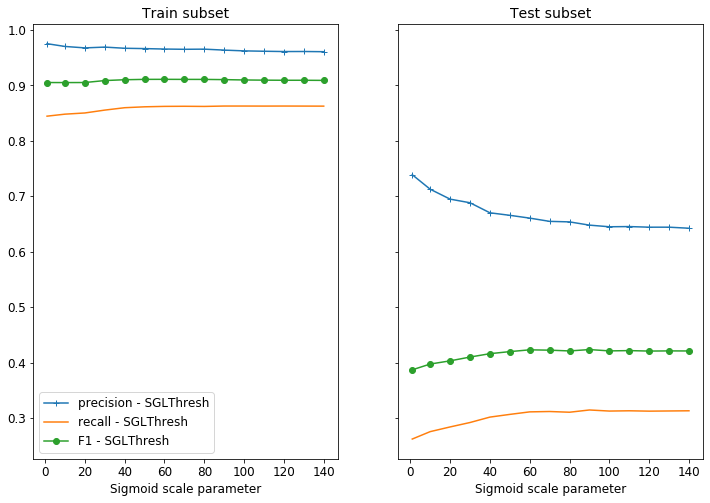

In [27]:
def plot_influence_de_a(scale_param_values, ptest, rtest, f1test, peval, reval, f1eval):
    
    fontsize=12
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,8))

    xlimsup=140
#     xlimsup=30
    
    ax1.plot(scale_param_values, ptest, '-+', label='precision - SGLThresh')
    ax1.plot(scale_param_values, rtest, label='recall - SGLThresh')
    ax1.plot(scale_param_values, f1test, '-o', label='F1 - SGLThresh')
#     ax1.plot([1, xlimsup], [0.5678, 0.5678], '-.', label='F1 - static')
#     ax1.plot([1, xlimsup], [0.6128, 0.6128], '--', label='F1 - numThresh')
    ax1.legend(fontsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.set_xlabel('Sigmoid scale parameter',fontsize=fontsize)
#     ax1.set_ylim([0.52, 0.66])
    ax1.set_title("Train subset",fontsize=14)
    
    ax2.plot(scale_param_values, peval, '-+', label='precision - SGLThresh')
    ax2.plot(scale_param_values, reval, '-', label='recall - SGLThresh')
    ax2.plot(scale_param_values, f1eval, '-o', label='F1 - SGLThresh')
#     ax2.plot([1, xlimsup], [0.5509, 0.5509], '-.', label='F1 - static')
#     ax2.plot([1, xlimsup], [0.5828, 0.5828], '--', label='F1 - numThresh')
#     ax2.legend(fontsize=fontsize)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.set_xlabel("Sigmoid scale parameter",fontsize=fontsize)
    ax2.set_title("Test subset",fontsize=14)
#     plt.suptitle("BCE objective",fontsize=16)
#     plt.savefig("influence_du_sigmoid_scale_param_objective_BCE.png")
#     plt.suptitle("F1 objective",fontsize=16)
#     plt.savefig("datasets/emotions/influence_du_sigmoid_scale_param_objective_F1_LabelPowerset.png")
#     plt.savefig("datasets/emotions/influence_du_sigmoid_scale_param_objective_F1_myNetwork.png")

metrics_array = np.array(metrics_list)
scale_param_values = np.array(scale_param_values_list)
# scale_param_values = np.array(range(1, 80, 5))
plot_influence_de_a(scale_param_values, metrics_array[:,0], metrics_array[:,1], metrics_array[:,2], metrics_array[:,3], metrics_array[:,4], metrics_array[:,5])    

# NumThresh

In [12]:
from opt import Adam
from sklearn import metrics

## utility function for F1 with multiprocessing: TODO

In [ ]:
# # multiprocessing

# def calculate_f1(y_true, output, thresholds, average):
#     """Calculate F1 score.
#     Args:
#       y_true: (N, (optional)frames_num], classes_num)
#       output: (N, (optional)[frames_num], classes_num)
#       thresholds: (classes_num,), initial thresholds
#       average: 'micro' | 'macro'
#     """
#     if y_true.ndim == 3:
#         (N, T, F) = y_true.shape
#         y_true = y_true.reshape((N * T, F))
#         output = output.reshape((N * T, F))

#     classes_num = y_true.shape[-1]
#     binarized_output = np.zeros_like(output)
# #     print('class num:', classes_num)
    
#     for k in range(classes_num):
#         binarized_output[:, k] = (np.sign(output[:, k] - thresholds[k]) + 1) // 2

#     if average == 'micro':
#         return metrics.f1_score(y_true.flatten(), binarized_output.flatten())
    
#     f1_array = []
#     for k in range(classes_num):
#         f1_array.append(metrics.f1_score(y_true[:, k], binarized_output[:, k]))

#     if average == 'macro':
#         return np.average(f1_array)
#     elif average is None:
#         return f1_array
#     else:
#         raise Exception('Incorrect argument!')


        
# def single_class_calculate_at_gradient(y_true, output, average, thresholds):
# # def single_class_calculate_at_gradient(params):
#     """Used with multiprocessing"""
    
# #     print("params", len(params))
# #     print(params)
# #     thresholds, y_true, output, average = params
    
#     classes_num = len(thresholds)
#     delta = 0.01
#     grads = []
    
#     f1 = calculate_f1(y_true, output, thresholds, average)
    
#     for k, threshold in enumerate(thresholds):
#         new_thresholds = thresholds.copy()
#         cnt = 0
#         while cnt < classes_num:
#             cnt += 1
#             new_thresholds[k] += delta
#             f1_new = calculate_f1(y_true, output, new_thresholds, average)
#             if f1_new != f1:
#                 break

#         grad = (f1_new - f1) / (delta * cnt)
#         grads.append(grad)
#         return grads
        
        
# def calculate_at_gradient(y_true, output, thresholds, average):
#     """Calculate gradient of thresholds numerically.
#     Args:
#       y_true: (N, (optional)frames_num], classes_num)
#       output: (N, (optional)[frames_num], classes_num)
#       thresholds: (classes_num,), initial thresholds
#       average: 'micro' | 'macro'
#     Returns:
#       grads: vector
#     """
#     f1 = calculate_f1(y_true, output, thresholds, average)
#     classes_num = len(thresholds)
# #     delta = 0.01
# #     grads = []
    
# #     print("calculate_at_gradient, f1:", f1)
#     nb_lists_comprised_of_ten_thresh = len(thresholds)//10
    
#     ten_threshold_chunks = [thresholds[i*10:(i+1)*10] for i in range(nb_lists_comprised_of_ten_thresh)]
#     print("ten_threshold_chunks", len(ten_threshold_chunks))
#     print(ten_threshold_chunks[0])
#     print(ten_threshold_chunks[-1])
    
#     pool = Pool(processes=10)
#     func = partial(single_class_calculate_at_gradient, y_true, output, average)
    
#     gradients = pool.map(func, ten_threshold_chunks)
    
#     return gradients


# def optimize_at_with_gd(y_true, output, thresholds, average):
#     """Optimize thresholds for AT.
#     Args:
#       y_true: (N, (optional)frames_num], classes_num)
#       output: (N, (optional)[frames_num], classes_num)
#       thresholds: (classes_num,), initial thresholds
#       average: 'micro' | 'macro'
#     Returns:
#       metric: float
#       thresholds: vector
#     """
#     opt = Adam()
#     opt.alpha = 1e-2
#     metric_asfo_epoch = []
    
# #     n_epochs = 100
#     n_epochs = 1
    
#     for i in range(n_epochs):
#         grads = calculate_at_gradient(y_true, output, thresholds, average)
# #         if i==0: print("grads:", grads)
#         grads = [-e for e in grads]
#         thresholds = opt.GetNewParams(thresholds, grads)
#         metric = calculate_f1(y_true, output, thresholds, average)
#         if i%50==0:
#             print('Iteration: {}, Score: {:.3f}, thresholds: {}'.format(
#                 i, metric, np.array(thresholds)))
#         metric_asfo_epoch.append(metric)
        
#     return metric, thresholds, metric_asfo_epoch


In [ ]:
l = [[1], [2]]
t = tuple(l)
l, t

## utility function for F1 w/o multiprocessing

In [13]:
def calculate_f1(y_true, output, thresholds, average):
    """Calculate F1 score.
    Args:
      y_true: (N, (optional)frames_num], classes_num)
      output: (N, (optional)[frames_num], classes_num)
      thresholds: (classes_num,), initial thresholds
      average: 'micro' | 'macro'
    """
    if y_true.ndim == 3:
        (N, T, F) = y_true.shape
        y_true = y_true.reshape((N * T, F))
        output = output.reshape((N * T, F))

    classes_num = y_true.shape[-1]
    binarized_output = np.zeros_like(output)

    for k in range(classes_num):
        binarized_output[:, k] = (np.sign(output[:, k] - thresholds[k]) + 1) // 2

    if average == 'micro':
        return metrics.f1_score(y_true.flatten(), binarized_output.flatten())
    
    f1_array = []
    for k in range(classes_num):
        f1_array.append(metrics.f1_score(y_true[:, k], binarized_output[:, k]))

    if average == 'macro':
        return np.average(f1_array)
    elif average is None:
        return f1_array
    else:
        raise Exception('Incorrect argument!')


def calculate_at_gradient(y_true, output, thresholds, average):
    """Calculate gradient of thresholds numerically.
    Args:
      y_true: (N, (optional)frames_num], classes_num)
      output: (N, (optional)[frames_num], classes_num)
      thresholds: (classes_num,), initial thresholds
      average: 'micro' | 'macro'
    Returns:
      grads: vector
    """
    f1 = calculate_f1(y_true, output, thresholds, average)
    delta = 0.01
    grads = []

    for k, threshold in enumerate(thresholds):
        new_thresholds = thresholds.copy()
        delta = 0.01
        cnt = 0
        while cnt < 10:
            cnt += 1
            new_thresholds[k] += delta
            f1_new = calculate_f1(y_true, output, new_thresholds, average)

            if f1_new != f1:
                break

        grad = (f1_new - f1) / (delta * cnt)
        grads.append(grad)

    return grads


def optimize_at_with_gd(y_true, output, thresholds, average):
    """Optimize thresholds for AT.
    Args:
      y_true: (N, (optional)frames_num], classes_num)
      output: (N, (optional)[frames_num], classes_num)
      thresholds: (classes_num,), initial thresholds
      average: 'micro' | 'macro'
    Returns:
      metric: float
      thresholds: vector
    """
    opt = Adam()
    opt.alpha = 1e-2
    metric_asfo_epoch = []
    for i in range(100):
        grads = calculate_at_gradient(y_true, output, thresholds, average)
        grads = [-e for e in grads]
        thresholds = opt.GetNewParams(thresholds, grads)
        metric = calculate_f1(y_true, output, thresholds, average)
        if i%50==0:
            print('Iteration: {}, Score: {:.3f}, thresholds: {}'.format(
                i, metric, np.array(thresholds)))
        metric_asfo_epoch.append(metric)
        fin=time.time()-debut
        print(" epoch duration: %.0f sec"%fin)
    return metric, thresholds, metric_asfo_epoch


## numerical application

In [16]:
nb_classes=159
debut = time.time()
print("computation start time:", debut)

t=0.3
thresh = [t]*nb_classes

average = 'micro'

manual_thres_f1 = calculate_f1(y_test_numpy, test_outputs_numpy, thresholds=thresh, average=average)
print('test manual_thres f1: {:.3f}'.format(manual_thres_f1))

p2, r2, fscore2, support = precision_recall_fscore_support(y_test_numpy, (test_outputs_numpy>thresh)*1, 
                                                           pos_label=1, average=average)

# Optimize thresholds
(auto_thres_f1, auto_thresholds, metric_asfo_epoch) = optimize_at_with_gd(y_train_numpy, train_outputs_numpy, 
                                                                          thresh, average=average)

print_thresholds(auto_thresholds, nb_classes)
# print("%.3f %.3f"%(manual_thres_f1*100, fscore2*100))

print('test manual_thres f1: {:.3f}'.format(manual_thres_f1))
print('test auto_thres f1: {:.3f}'.format(auto_thres_f1))

print("computation start time: %.0f sec"%debut, "end time: %.0f sec"%(time.time()))
fin=time.time()-debut
print("computation duration: %.0f sec"%fin)

computation start time: 1584534312.4281003
test manual_thres f1: 0.424
Iteration: 0, Score: 0.903, thresholds: [0.30541829 0.29781373 0.29861826 0.29468563 0.3        0.29634972
 0.29156819 0.30790184 0.3        0.30394852 0.3        0.3
 0.29781373 0.3        0.30790184 0.30790184 0.29382932 0.3
 0.30210091 0.30394852 0.3        0.2980762  0.30932352 0.29156819
 0.3        0.3        0.3        0.29536711 0.30541829 0.30306787
 0.3        0.3        0.3        0.3        0.3        0.30210091
 0.29634972 0.3        0.3        0.3        0.3        0.3
 0.30306787 0.3        0.30249696 0.3        0.30394852 0.30651858
 0.3        0.30249696 0.3        0.30541829 0.30790184 0.29156819
 0.29828328 0.30181142 0.3        0.3        0.30181142 0.3
 0.3        0.29382932 0.3        0.29382932 0.3        0.30127873
 0.30790184 0.30249696 0.30306787 0.30394852 0.3        0.3
 0.30541829 0.3        0.3        0.30790198 0.29634972 0.30249696
 0.3        0.2980762  0.30306787 0.30541829 0.303067

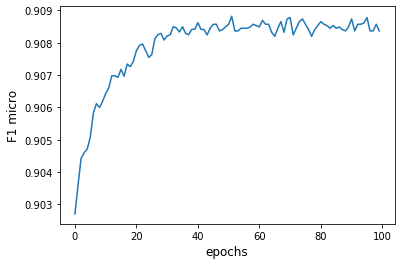

In [17]:
plt.plot(metric_asfo_epoch)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("F1 micro", fontsize=12)
plt.savefig("bibtex_F1_micro_asof_epochs_numThresh.png")

In [18]:
print_thresholds(auto_thresholds, nb_classes)
train_pred = train_outputs_numpy>auto_thresholds
test_pred = test_outputs_numpy>auto_thresholds
print('train')
print_scores(y_train, train_pred)
# compute_accuracy_from_numpy_tensors(y_train_numpy, train_pred)
print('test')
print_scores(y_test, test_pred)
# compute_accuracy_from_numpy_tensors(y_test_numpy, test_pred)

auto_thresholds 0.3863 0.2936 0.3092 0.2620 0.3000 0.2869 0.2926 0.4791 0.3000 0.3479 0.3000 0.3000 0.2112 0.3000 0.5405 0.3231 0.2648 0.3000 0.4326 0.3386 0.3000 0.2313 0.4193 0.2619 0.3000 0.3000 0.3000 0.2779 0.4977 0.4602 0.3000 0.3000 0.3000 0.3000 0.3000 0.3795 0.2329 0.3000 0.3000 0.3000 0.3000 0.3000 0.6504 0.3000 0.3482 0.3000 0.4015 0.4950 0.3000 0.3974 0.3000 0.3864 0.3941 0.1576 0.2422 0.5971 0.3000 0.3000 0.4552 0.3000 0.3000 0.3020 0.3000 0.2858 0.3000 0.5651 0.3031 0.3406 0.3336 0.3274 0.3000 0.3000 0.3805 0.3000 0.3000 0.3168 0.2934 0.3524 0.3000 0.2611 0.3365 0.3474 0.3396 0.3606 0.3474 0.4147 0.2375 0.3000 0.4420 0.2149 0.3000 0.3000 0.3000 0.4747 0.3733 0.4698 0.3000 0.3599 0.3000 0.3000 0.5221 0.3000 0.3000 0.3646 0.3685 0.3085 0.3000 0.0834 0.3000 0.3000 0.2945 0.6329 0.1853 0.2960 0.3000 0.3000 0.3000 0.3170 0.2201 0.3000 0.3000 0.3768 0.2747 0.3000 0.3517 0.3000 0.3000 0.3000 0.3474 0.2556 0.2158 0.2925 0.3000 0.3000 0.3805 0.2010 0.3000 0.3000 0.3000 0.2982 0.50

/home/thomas/tools/miniconda2/envs/keras-sincnet-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
train
micro: p:83.38 r:43.07 f1:56.80
macro: p:70.37 r:31.97 f1:37.60
test
micro: p:70.68 r:26.67 f1:38.72
macro: p:35.39 r:16.45 f1:19.58

## for BCE

In [ ]:
def BCE_numpy(y_gt, y_pred):
    epsilon=1e-12
    return np.mean(-y_gt*np.log(y_pred+epsilon)-(1-y_gt)*np.log(1-y_pred+epsilon))
    

def calculate_BCE(y_true, output, thresholds, average):
    """Calculate BCE score.
    Args:
      y_true: (N, (optional)frames_num], classes_num)
      output: (N, (optional)[frames_num], classes_num)
      thresholds: (classes_num,), initial thresholds
      average: 'micro' | 'macro'
    """
    if y_true.ndim == 3:
        (N, T, F) = y_true.shape
        y_true = y_true.reshape((N * T, F))
        output = output.reshape((N * T, F))

    classes_num = y_true.shape[-1]
    binarized_output = np.zeros_like(output)
#     print('class num:', classes_num)
    
    for k in range(classes_num):
        binarized_output[:, k] = (np.sign(output[:, k] - thresholds[k]) + 1) // 2

    if average == 'micro':
        return BCE_numpy(y_true.flatten(), binarized_output.flatten())
    
    bce_array = []
    for k in range(classes_num):
        bce_array.append(BCE_numpy(y_true[:, k], binarized_output[:, k]))

    if average == 'macro':
        return np.average(bce_array)
    elif average is None:
        return bce_array
    else:
        raise Exception('Incorrect argument!')


def BCE_calculate_at_gradient(y_true, output, thresholds, average):
    """Calculate gradient of thresholds numerically.
    Args:
      y_true: (N, (optional)frames_num], classes_num)
      output: (N, (optional)[frames_num], classes_num)
      thresholds: (classes_num,), initial thresholds
      average: 'micro' | 'macro'
    Returns:
      grads: vector
    """
    bce = calculate_BCE(y_true, output, thresholds, average)
    classes_num = len(thresholds)
    
    delta = 0.01
    grads = []
#     print("calculate_at_gradient, bce:", bce)
    
    for k, threshold in enumerate(thresholds):
        new_thresholds = thresholds.copy()
        cnt = 0
        while cnt < 10:
            cnt += 1
            new_thresholds[k] += delta
            bce_new = calculate_BCE(y_true, output, new_thresholds, average)
            if bce_new != bce:
                break

        grad = (bce_new - bce) / (delta * cnt)
        grads.append(grad)

    return grads


def BCE_optimize_at_with_gd(y_true, output, thresholds, average):
    """Optimize thresholds for AT.
    Args:
      y_true: (N, (optional)frames_num], classes_num)
      output: (N, (optional)[frames_num], classes_num)
      thresholds: (classes_num,), initial thresholds
      average: 'micro' | 'macro'
    Returns:
      metric: float
      thresholds: vector
    """
    opt = Adam()
    opt.alpha = 1e-2
    metric_asfo_epoch = []
    print("start time:", debut)
    for i in range(100):
        grads = BCE_calculate_at_gradient(y_true, output, thresholds, average)
#         if i==0: print("grads:", grads)
        grads = [-e for e in grads]
        thresholds = opt.GetNewParams(thresholds, grads)
        metric = calculate_f1(y_true, output, thresholds, average)
        if i%50==0:
            print('Iteration: {}, F1 Score: {:.3f}, thresholds: {}'.format(
                i, metric, np.array(thresholds)))
        metric_asfo_epoch.append(metric)
    
    fin=time.time()-debut
    print("duration:", fin)
        
    return metric, thresholds, metric_asfo_epoch


## numerical application with BCE

In [ ]:
t=0.3
thresh = [t]*nb_classes

average = 'micro'

manual_thres_f1 = calculate_f1(y_test_numpy, test_pred_numpy, thresholds=thresh, average=average)
p2, r2, fscore2, support = precision_recall_fscore_support(y_test, (test_pred_numpy>thresh)*1, 
                                                           pos_label=1, average=average)

# Optimize thresholds
(auto_thres_bce, auto_thresholds, metric_asfo_epoch) = BCE_optimize_at_with_gd(y_train_numpy, train_outputs_numpy, 
                                                                          thresh, average=average)

print_thresholds(auto_thresholds, nb_classes)
# print("%.3f %.3f"%(manual_thres_f1*100, fscore2*100))

auto_thres_f1 = calculate_f1(y_test_numpy, test_pred_numpy, thresholds=auto_thresholds, average=average)

print('test manual_thres f1: {:.3f}'.format(manual_thres_f1))
print('test auto_thres f1: {:.3f}'.format(auto_thres_f1))
